# Gutierrez and Deneve 2019
## Recurrent spiking autoencoder with adaptation
doi: 10.7554/eLife.46926

The author of this eLife paper derived a spiking auto-encoding RNN from a simple quadratic objective.

At any given moment, the rate, $r$, of each neuron can be read out via a decoding weight $w$ to reconstruct the input stimulus $\phi$ as $\hat{\phi}$,
$$
\hat{\boldsymbol{\phi}}(t)=\sum_{i} w_{i} r_{i}(t).
$$

The TLDR is that the network greedily optimizes the objective $E$ input reconstruction + L2 rate history regularizer, 
$$E(t) = (\phi(t) -\hat{\phi}(t))^2 + \mu \parallel f(t) \parallel_2^2$$
where $f(t)$ is a low-pass history filter on rates of a neuron, and $\mu$ is a constant.
It's greedy because only one neuron spikes at a time, meaning similarly-tuned neurons will effectively be competing with and inhibiting each other.
The results rest on the assumption that there is some decoder whose weights $w$ fully determine the network's encoding and recurrent weights in conjunction with the rate penalty $\mu$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Simulation set-up
We're going to have a 2D input representing some oriented input `theta`, and 200 neurons with uniformly-distributed tuning preference for orientation. 
The stimulus over time will be `phi`, and its time derivative is `dphi`.
There are two neurons tuned to each unique orientation `theta` -- one with high gain and one with low gain.

I construct the weight matrix `W`, gains matrix `G`, and `phi` and `dphi` below, and set the time constants for the sim.

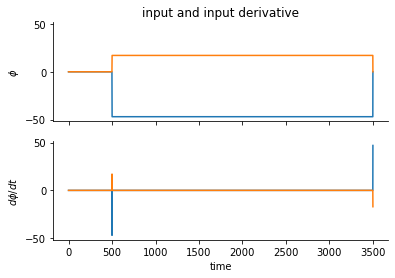

In [46]:
# time 
dt = 1  # units: msec
time = np.arange(0, 3.5E3+dt, dt)

# params
nj = 2  # input dim
nn = 200  # n neurons

tau = 5  # shorter tau --> more variance in estimate, recruits more neurons
tau_a = 2000  
mu = .1

sgain = 50
stime = np.arange(.5E3//dt, 3.5E3//dt, dtype=int)

# connectivity
nw = nn//2
theta = np.arange(0, 2*np.pi, 2*np.pi/nw)
theta = np.stack([theta, theta], 1)
theta = np.reshape(theta, -1)

bgain1, bgain2 = (3., 9) # (3, 9)
bgain = np.tile([bgain1, bgain2], nw)

W = np.stack([np.cos(theta) * bgain, np.sin(theta) * bgain])
Gain = np.diag(np.diag(2./(W.T@W + mu)))
thresh = 1
eta = 10.  # linear cost factor

# noise and inputs
pp = 18 # increase this to increase the resolution of the transfer functions
thetp = np.arange(0, 2*np.pi, 2*np.pi/pp)

phi = np.zeros((nj, len(time)))
test_thet = thetp[8]  # which ori to plot
phi[0,stime] = np.cos(test_thet) * sgain
phi[1,stime] = np.sin(test_thet) * sgain

dphi = np.hstack([np.zeros((nj,1)), np.diff(phi,1,1)])  # if s has extra dims

fig, ax = plt.subplots(2,1, sharex="all", sharey="all")
ax[0].plot(phi.T)
ax[1].plot(dphi.T);
ax[0].set(ylabel=r"$\phi$", title="input and input derivative")
ax[1].set(xlabel="time", ylabel=r"$d{\phi}/dt$")
sns.despine()

# Simulate w/ Euler iteration

The voltage dynamics are given by
$$
\tau \dot{V}_{i}=-V_{i}+g_{i} w_{i}(\tau \dot{\phi}+\phi)-\tau g_{i} \sum_{j} \Omega_{i j} o_{j} - \kappa_{i} f_{i}.
$$

where the taus are time constants, and $\kappa_{i}=\mu g_{i}\left(1-\frac{\tau}{\tau_{a}}\right)$. 
What is interesting is the lack of an explicit $\hat{\phi}$ reconstruction term.
There is a $\dot{\phi}$ (dot) term, implying a neuron must receive both the stimulus input as well as the stimulus time-derivative.
This dynamical system means that each neuron's voltage has an additional leak term (last term) that is dependent on its own spiking history.
Another way to think about this (and how it is implemented in the simulation) is that its spiking threshold is dynamically changing.

The other terms are defined below.
The rate is given by a low-pass over recent spiking output $o(t)$
$$
\dot{r}_{i}=-\frac{1}{\tau} r_{i}+o_{i}
$$
The subtractive adaptation signal $f$ is the spike history over a long time window.
$$
\dot{f}_{i}=-\frac{1}{\tau_{a}} f_{i}+o_{i}
$$

The gain of each neuron $i$ is determined by the regularization constant and the decoding weights.
$$
g_{i} = 1 /\left(w_{i}^{2}+\mu\right)
$$
The lateral recurrent weights are also determiend by the decoding weights and regularization constant.
$$
\Omega_{i j}=w_{i} w_{j}+\mu \delta_{i j}
$$
All the following time-varying variables are simulated:
- `v` : varying voltage 
- `o` : spiking output
- `r` : rate (short time constant low-pass filter on spike count)
- `f` : rate history (long time constant low-pass filter on spike count)
- `phi_hat` : estimated reconstructed input given the network spikes at any given moment

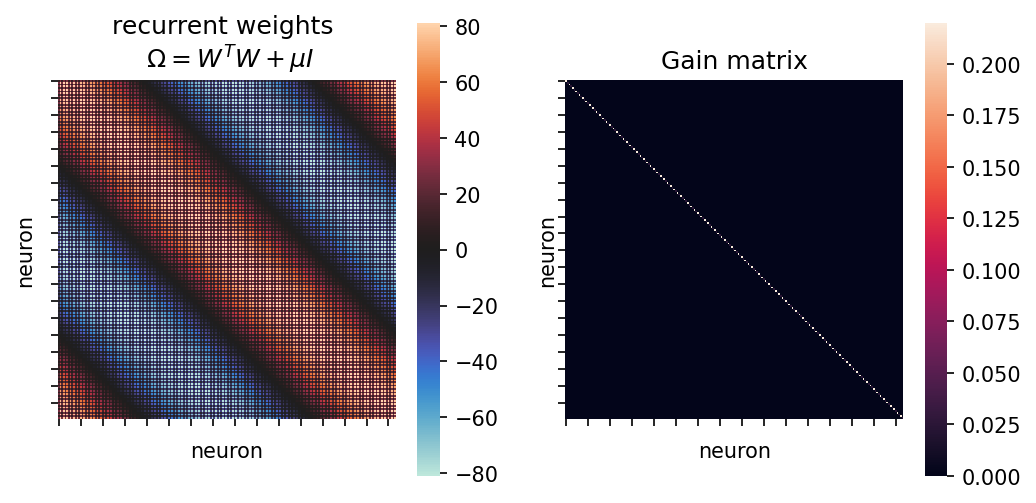

In [45]:
# init 
o = np.zeros((nn, len(time)))
r = np.zeros((nn, len(time)))
f = np.zeros((nn, len(time)))
v = np.zeros((nn, len(time)))
phi_hat = np.zeros((nj, len(time)))

# input is a function of phi and dphi, as well as ofc the weights and gains
feedfwd = Gain @ W.T @ (phi + tau * dphi)
Omega = W.T @ W + np.eye(nn)*mu  # recurrent weights
Kappa = ((tau/tau_a)-1)*mu*Gain  # adaptation term, like an extra leak term

fig, ax = plt.subplots(1,2,sharex="all", sharey="all", figsize=(8,4), dpi=150)
sns.heatmap(Omega, ax=ax[0], square=True, cmap="icefire")
sns.heatmap(Gain, ax=ax[1], square=True)
ax[0].set(xticklabels=[], yticklabels=[], xlabel="neuron", ylabel="neuron", title="recurrent weights \n $\Omega=W^T W + \mu I$")
ax[1].set(xticklabels=[], yticklabels=[], xlabel="neuron", ylabel="neuron", title="Gain matrix");

## Run simulation

In [47]:
pbar = tqdm(range(len(time)))
for t in pbar:
    # voltage dynamics
    dvdt = -v[:,t-1] + feedfwd[:,t-1] - tau*Gain@Omega@O[:,t-1] + Kappa@f[:,t-1]
    v[:,t] = v[:,t-1] + dt * (dvdt/tau)

    # adaptive threshold and binary spiking output
    adaptive_thresh = thresh + eta*np.diag(Gain)
    o[:,t] = (v[:,t] >= adaptive_thresh)/dt # threshold crossing neurons spike

    # greedy spiking -- only allow argmax(voltage-adaptive_thresh) to fire suppress remaining neurons
    if o[:,t].sum() > 1/dt:  
        vi = np.argmax(v[:,t] - adaptive_thresh)  # determine winner neuron
        o[:,t] = 0  # suppress all
        o[vi,t] = 1/dt  # allow only 1 to spike

    # rate dynamics
    dr = -(1/tau) * r[:,t-1] + o[:,t-1]
    r[:,t] = r[:,t-1] + dt*dr

    # rate history dynamics (much longer timescale tau_a >> tau)
    df = - (1/tau_a) * f[:,t-1] + o[:,t-1]
    f[:,t] = f[:,t-1] + dt*df

    # decoder, i.e. reconstructed stimulus dynamics
    dphi_hat = -(1/tau) * phi_hat[:,t-1] + W@o[:,t-1]
    phi_hat[:,t] = phi_hat[:,t-1] + dt*dphi_hat

  0%|          | 0/3501 [00:00<?, ?it/s]

# Plot simulation

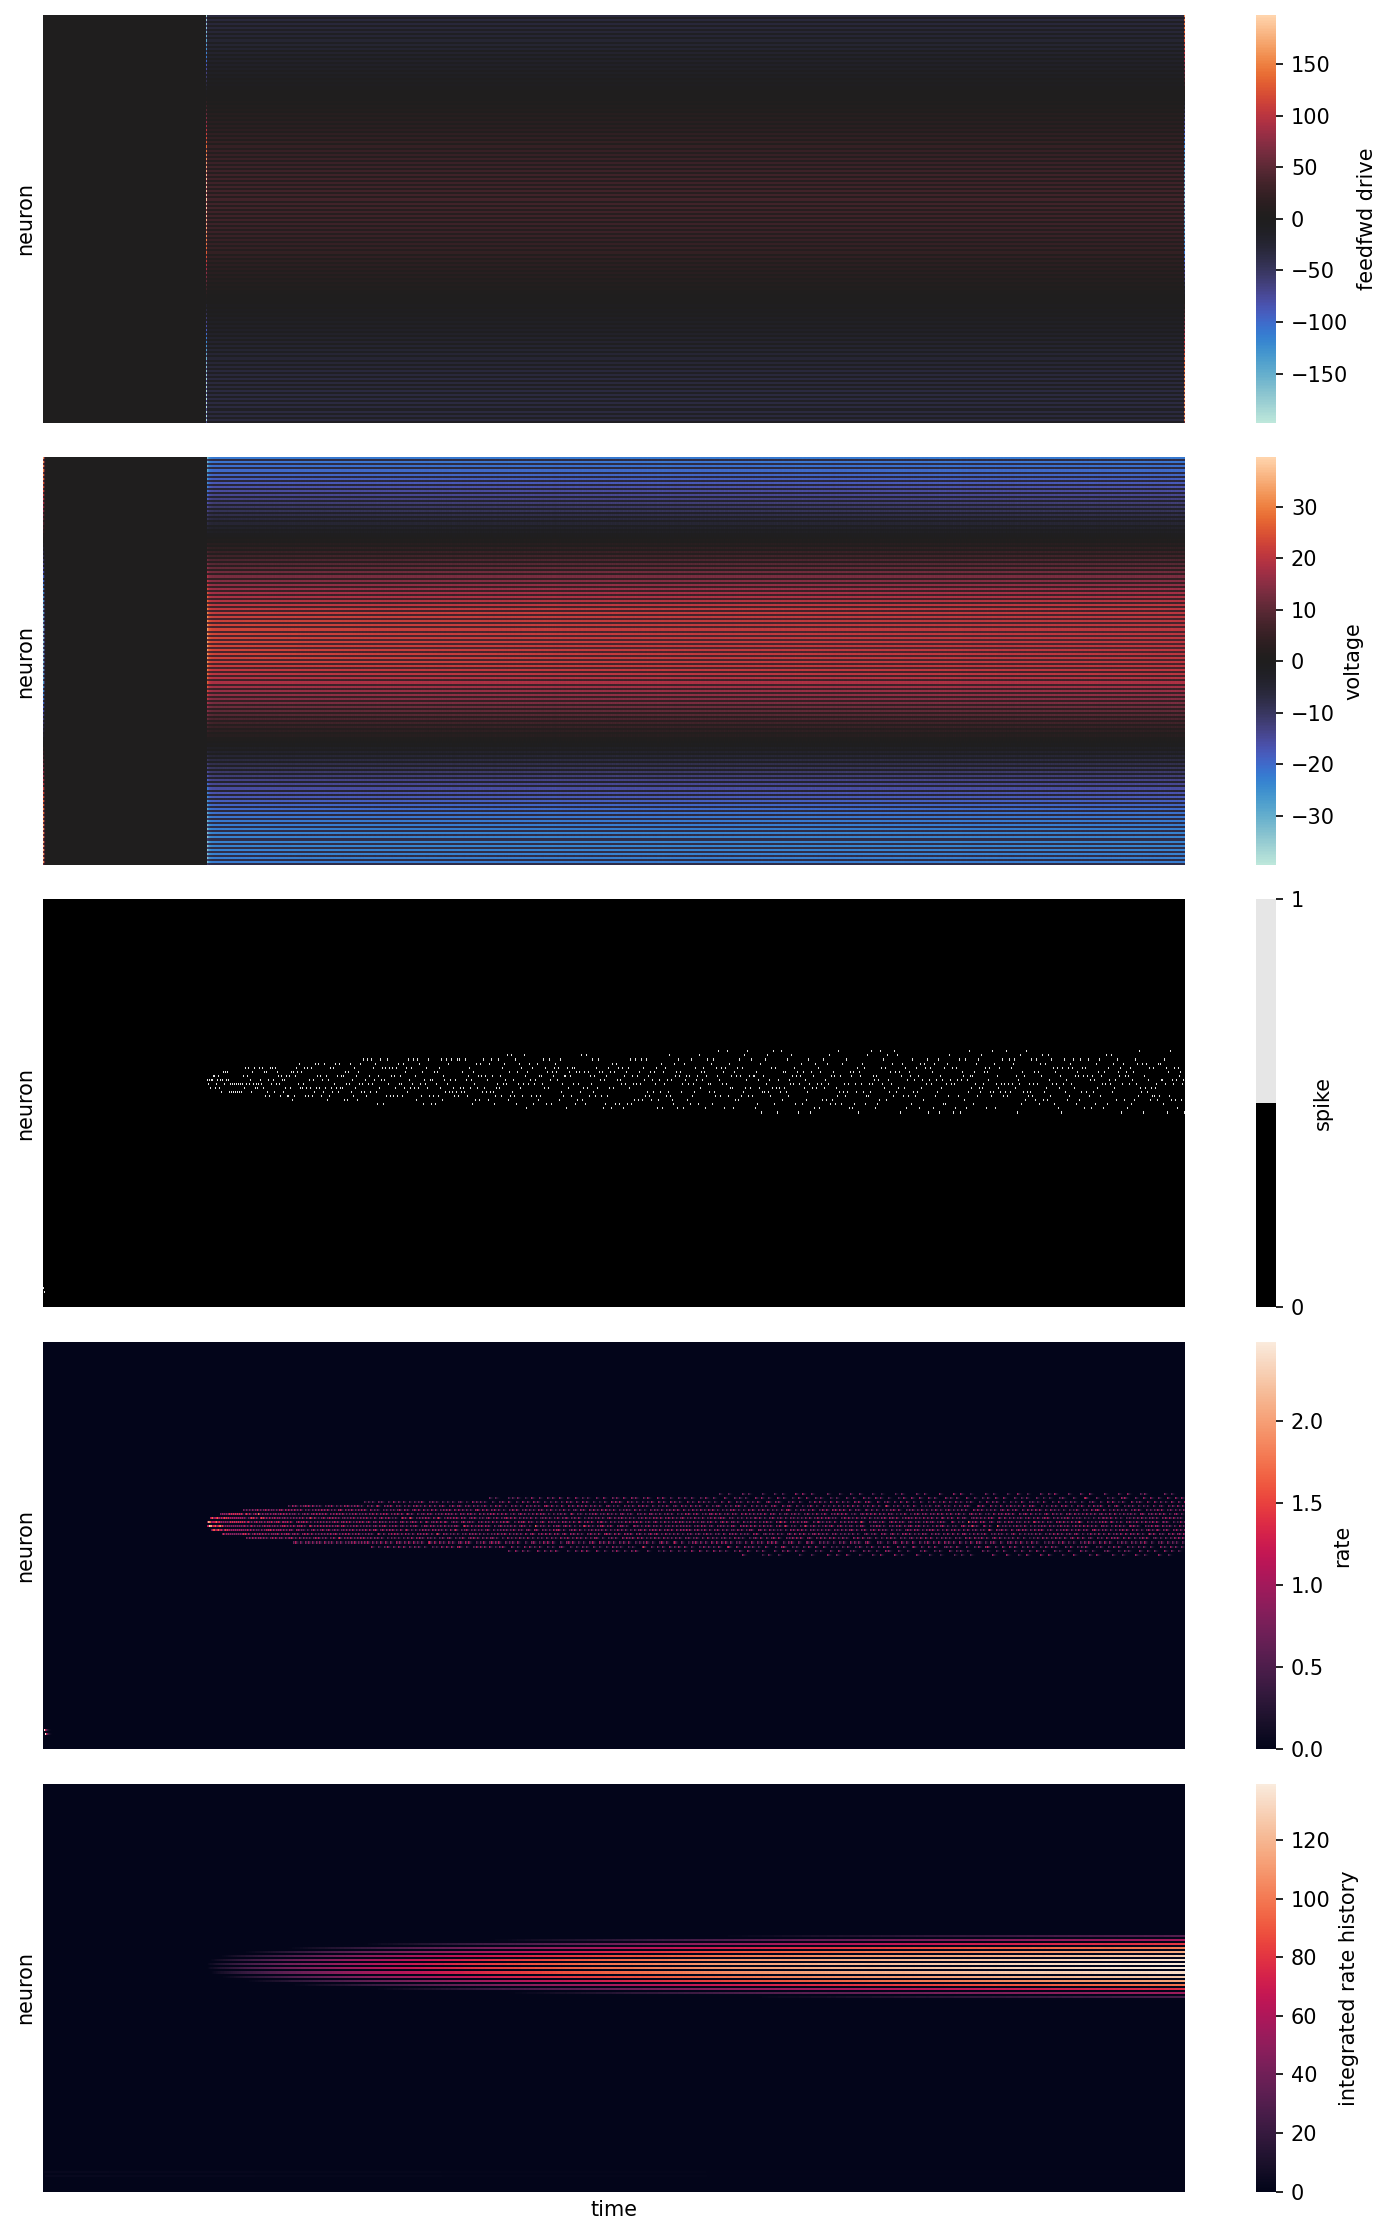

In [43]:
def maxmin(x):
    return np.max(np.squeeze(np.abs(x)))

fig, ax = plt.subplots(5, 1, dpi=150, sharex="all", figsize=(10,15))
sns.heatmap(feedfwd, cmap="icefire", vmin=-maxmin(feedfwd), vmax=maxmin(feedfwd),rasterized=True, ax=ax[0], cbar_kws={"label": "feedfwd drive"})
sns.heatmap(v, cmap="icefire", vmin=-maxmin(v), vmax=maxmin(v), rasterized=True, ax=ax[1], cbar_kws={"label": "voltage"})
sns.heatmap(o, cmap=[(0,0,0), (.9,.9,.9)], rasterized=True, ax=ax[2], cbar_kws={"ticks": (0,1), "label": "spike"})
sns.heatmap(r, cmap="rocket", vmin=0, vmax=maxmin(r), rasterized=True, ax=ax[3], cbar_kws={"label": "rate"})
sns.heatmap(f, cmap="rocket", vmin=0, vmax=maxmin(f), rasterized=True, ax=ax[4], cbar_kws={"label": "integrated rate history"})

ax[0].set(ylabel="neuron", yticks=[])
ax[1].set(ylabel="neuron",  yticks=[])
ax[2].set(ylabel="neuron",  yticks=[])
ax[3].set(ylabel="neuron",  yticks=[])
ax[4].set(xticks=[], xlabel="time", ylabel="neuron", yticks=[]);
fig.tight_layout()

## What does the 2D input and reconstructed output look like?

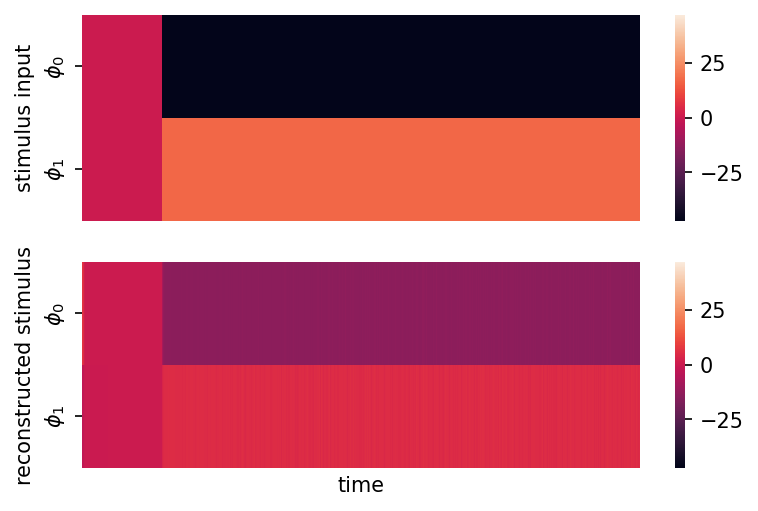

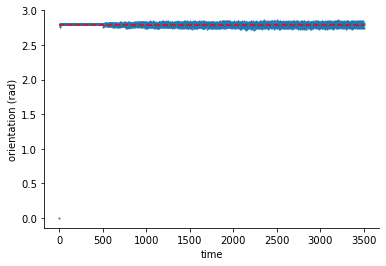

In [17]:
fig, ax = plt.subplots(2,1, sharex="all", sharey="all", dpi=150)
abs_peak = np.max(np.abs(np.concatenate([np.squeeze(phi), np.squeeze(phi_hat)])))
sns.heatmap(phi, vmin=-abs_peak, vmax=abs_peak, ax=ax[0])
sns.heatmap(phi_hat, vmin=-abs_peak, vmax=abs_peak, ax=ax[1])
ax[0].set(ylabel="stimulus input")
ax[1].set(xticks=[], xlabel="time", ylabel="reconstructed stimulus", yticklabels=[r"$\phi_0$", r"$\phi_1$"]);

fig, ax = plt.subplots(1,1)
ax.hlines(thetp[8], 0, 3500, "r", linestyle="--")
ax.scatter(range(len(phi_hat[0])), np.mod(np.arctan2(phi_hat[1], phi_hat[0]), np.pi), s=1)
ax.set(xlabel="time", ylabel="orientation (rad)")
sns.despine()

## Relationship between neuron gain and decoding weight

What the authors call the gain of each neuron is determined by their decoding weight.
Small decoding weights are associated with high-gain neurons, and large decoding weights are associated with low-gain neurons.

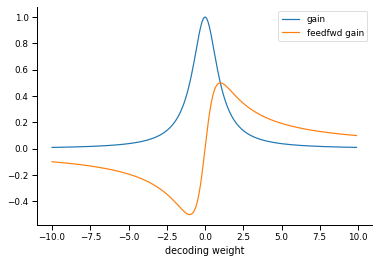

In [6]:
W2 = np.arange(-10, 10, .1)
mu2 = 1
gain = 1 / (W2*W2 + mu2)
gain_feedfwd = W2 / (W2*W2 + mu2)

with sns.plotting_context("paper"):
    fig, ax = plt.subplots(1, 1)
    ax.plot(W2, gain, label="gain")
    ax.plot(W2, gain_feedfwd, label="feedfwd gain")
    ax.set(xlabel="decoding weight")
    ax.legend()
    sns.despine()